<H3 align = "left"> Detecting Arrhythmia Variant using Electrocardiogram Data </H3>

In [13]:
##############################################
## Packages Needed for this Assignmnent ##
##############################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from statistics import mean
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [14]:
# Import the dataset
dataset = pd.read_csv("MIT-BIH Arrhythmia Database.csv")

TODO:
- take representative sample of dataset (aim for 15,000 rows)
- perform preprocessing 

In [15]:
# Random_state=42 ensures that each time this code runs, we will get the same N rows in the sample 
sampleOfData = dataset.sample(n=15000, random_state=777)

# To get different samples use sampleOfData = dataset.sample(n=NUMBER) 
#sampleOfData = dataset.sample(n=15000)


## Understanding the Data

- "record" is the name of the subject/patient.
- "type" is the target, which contains 5 categories of heartbeats:
    1. N (Normal)
    2. SVEB (Supraventricular ectopic beat)
    3. VEB (Ventricular ectopic beat)
    4. F (Fusion beat)
    5. Q (Unknown beat) <-- Will be removed because not so useful to our goal

## Data Visualization 

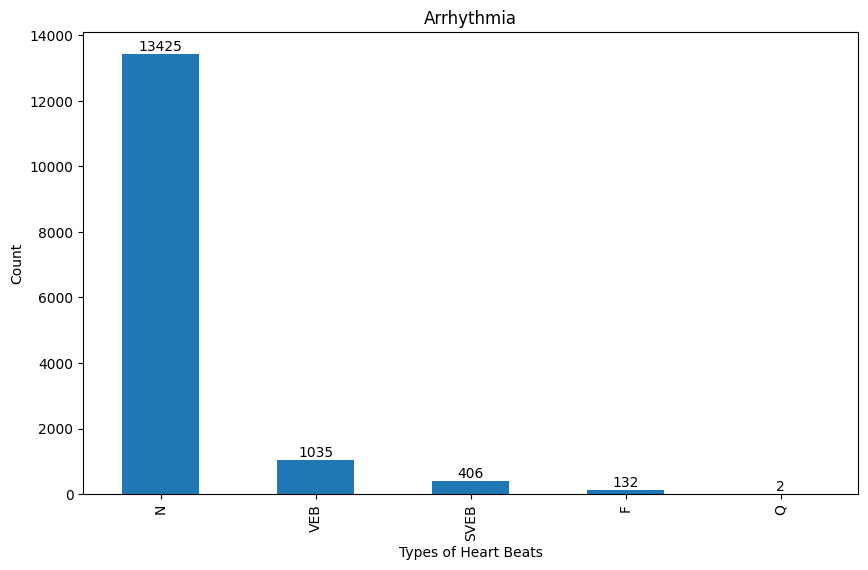

In [4]:
# Entire dataset 
# data = dataset['type'].value_counts()

# Sample dataset 
data = sampleOfData['type'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,6))
bars = data.plot(kind='bar')

# Set the title and labels
plt.title('Arrhythmia')
plt.xlabel('Types of Heart Beats')
plt.ylabel('Count')

for container in bars.containers:
    bars.bar_label(container)

# Show the plot
plt.show()

### Don't remove the comment below until final! It will take a lot of spaces

In [5]:
#data visualization (before data cleaning)
# features = sampleOfData.drop('type', axis=1).columns
# target = sampleOfData['type']

# fig, axs = plt.subplots(len(features), 1, figsize=(5, 5*len(features)))

# for i, feature in enumerate(features):
#     axs[i].scatter(sampleOfData[feature], target)
#     axs[i].set_xlabel(feature)
#     axs[i].set_ylabel('Heartbeat')

# plt.tight_layout()
# plt.show()

## Data cleaning

In [16]:
#we drop "record" column from our dataset because it is not helpful as "record" is the name of the subject/patient.
sampleOfData.drop('record', axis=1, inplace=True)

In [17]:
# Function to replace outliers with the mean of that column (NOTE: I USED SAMPLEDATA NOT DATA)
def replaceOutliers (sd, column):
    Q1 = sd[column].quantile(0.25)
    Q3 = sd[column].quantile(0.75)
    IQR = Q3 - Q1
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR

    # Calculating the mean W/O outliers 
    temp = sd[(sd[column] >= lowerBound) & (sd[column] <= upperBound)]
    mean = temp[column].mean()
    
    sd.loc[(sd[column] < lowerBound) | (sd[column] > upperBound), column] = mean
    return sd

# Columns we want to check for outliers 
columnCheck = [
    '0_pre-RR', '0_post-RR', '0_pPeak', '0_tPeak',
    '0_rPeak', '0_sPeak', '0_qPeak', '0_qrs_interval',
    '0_pq_interval', '0_qt_interval', '0_st_interval', '0_qrs_morph0',
    '0_qrs_morph1', '0_qrs_morph2', '0_qrs_morph3', '1_pre-RR', '1_post-RR',
    '1_pPeak', '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak',
    '1_qrs_interval', '1_pq_interval', '1_qt_interval', '1_st_interval', '1_qrs_morph0', '1_qrs_morph1',
    '1_qrs_morph2', '1_qrs_morph2', '1_qrs_morph4'
]

for col in columnCheck:
    sampleOfData = replaceOutliers(sampleOfData, col)


# Seeing if theres still same amount of rows after replacing outliers 
print(sampleOfData.shape)


(15000, 33)


In [18]:
#check for the null or missing value in the dataset
dataset.isnull().sum()
sampleOfData.isnull().sum()

type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      0
dtype: int64

In [19]:
#check for the number of duplicates in the dataset
dataset.duplicated().sum()
sampleOfData.duplicated().sum()


0

## Data Analysis

In [20]:
# Printing the Summary Statistics of the Sample Dataset 
print(sampleOfData.describe())

           0_pre-RR     0_post-RR       0_pPeak       0_tPeak       0_rPeak  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean     275.020301    275.275281      0.034390      0.363089      1.108694   
std       68.929384     67.847951      0.120581      0.728900      0.462368   
min       93.000000     95.000000     -0.321440     -2.006422     -0.246439   
25%      231.000000    232.000000     -0.053551     -0.255204      0.817955   
50%      267.000000    267.000000      0.017876      0.238855      1.108694   
75%      318.000000    317.000000      0.110570      0.921739      1.408655   
max      461.000000    458.000000      0.401217      2.702962      2.431187   

            0_sPeak       0_qPeak  0_qrs_interval  0_pq_interval  \
count  15000.000000  15000.000000    15000.000000   15000.000000   
mean      -0.140082     -0.070755       27.558305      10.119687   
std        1.031681      0.079133       13.451599       7.626826   
min       -2.837

In [11]:
# Visualizing the data after replacing the outliers with the mean (NOTE: i want to add this to data visualization seciton but this could only work after cleaning the data)
# for column in columnCheck:
#     plt.figure(figsize=(5, 2))
#     sns.boxplot(y=sampleOfData[column])
#     plt.title(column)
#     plt.show()

In [21]:
# Before we encode the data, we remove the target (in type) that is Q (unknown) because it is not beneficial to include these in our dataset
sampleOfData = sampleOfData[sampleOfData.type != "Q"]

# With encoder, F = 0, N = 1, SVEB = 2, VEB = 3, 
le = LabelEncoder()
sampleOfData['type'] = le.fit_transform(sampleOfData['type'])

<Axes: >

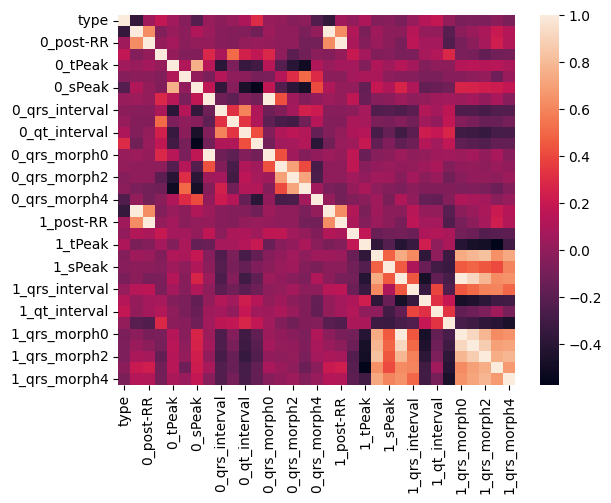

In [22]:
#check for correlations using heatmaps
correlation = sampleOfData.corr()
sns.heatmap(correlation)

Dataset distribution before SMOTE:
1    13425
3     1035
2      406
0      132
Name: type, dtype: int64
Dataset distribution after SMOTE:
1    13425
3    13425
2    13425
0    13425
Name: type, dtype: int64


/var/folders/cx/jj67ghxj5w9gsyhlcwjvf6540000gn/T/ipykernel_14081/2861652453.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_smote.value_counts().index, y=y_smote.value_counts().values, palette='deep')


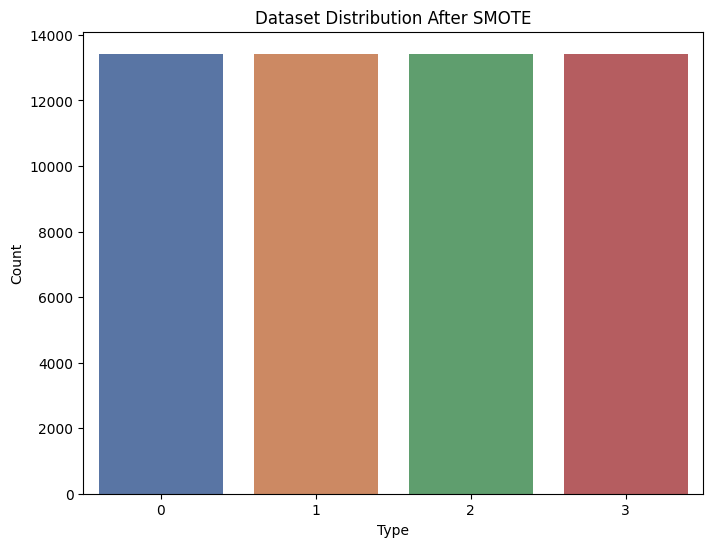

In [23]:
SampleDataset_smote = sampleOfData.copy()

#We are focusing on creating equal numbers for the type of heart beat
X = SampleDataset_smote.drop(columns=['type'])
y = SampleDataset_smote['type']

#Here is smote 
smote = SMOTE(random_state=777) 
X_smote, y_smote = smote.fit_resample(X, y)

#Combine the resampled features back into "dataset_smote"
SampleDataset_smote = pd.concat([X_smote, y_smote], axis=1) 

#Before
print("Dataset distribution before SMOTE:")
print(y.value_counts())

#After
print("Dataset distribution after SMOTE:")
print(y_smote.value_counts())

#Visualization via bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x=y_smote.value_counts().index, y=y_smote.value_counts().values, palette='deep')
plt.title('Dataset Distribution After SMOTE')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

#print(SampleDataset_smote.columns)

## Identify the most optimized model

### TODO: Decision Tree, Random Forest, and K-Nearest Neighbors
### TODO: Display results and visualization 

In [25]:
# Target --> identifying the type (N (Normal),  SVEB (Supraventricular ectopic beat)
# VEB (Ventricular ectopic beat), F (Fusion beat), and Q (Unknown beat))

# Features --> all other columns 
X = SampleDataset_smote.drop('type', axis=1)
y = SampleDataset_smote['type']


# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# Standardizing the features
scaler = StandardScaler()
X_trainScaled = scaler.fit_transform(X_train)
X_testScaled = scaler.transform(X_test)

# Logistic Regression 
logisticReg = LogisticRegression(max_iter=1000)
logisticReg.fit(X_trainScaled, y_train)
yPredLogReg = logisticReg.predict(X_testScaled)

accuracyLog = accuracy_score(y_test, yPredLogReg)
precision = precision_score(y_test, yPredLogReg, average='weighted')
recall = recall_score(y_test, yPredLogReg, average='weighted')
f1 = f1_score(y_test, yPredLogReg, average='weighted')
cm = confusion_matrix(y_test, yPredLogReg)

print (f"Logicstic Regression: ")
print(f"Accuracy: {accuracyLog}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(cm)
print()


# Logistic Regression --> Normalized 
normalizer = Normalizer()
X_trainedNormal = normalizer.fit_transform(X_train)
X_testNormal = normalizer.transform(X_test)

X_trainScaled = scaler.fit_transform(X_trainedNormal)
X_testScaled = scaler.transform(X_testNormal)

logisticReg = LogisticRegression(max_iter=1000)
logisticReg.fit(X_trainScaled, y_train)
yPredLogReg = logisticReg.predict(X_testScaled)

accuracyLog = accuracy_score(y_test, yPredLogReg)
precision = precision_score(y_test, yPredLogReg, average='weighted')
recall = recall_score(y_test, yPredLogReg, average='weighted')
f1 = f1_score(y_test, yPredLogReg, average='weighted')
cm = confusion_matrix(y_test, yPredLogReg)

print(f"Logistic Regression Normalized")
print(f"Accuracy: {accuracyLog}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(cm)
print()

# KNN
knn = KNeighborsClassifier()
knn.fit(X_trainScaled, y_train)
yPredKNN = knn.predict(X_testScaled)

accuracyKNN = accuracy_score(y_test, yPredKNN)
precisionKNN = precision_score(y_test, yPredKNN, average='weighted')
recallKNN = recall_score(y_test, yPredKNN, average='weighted')
f1KNN = f1_score(y_test, yPredKNN, average='weighted')
cmKNN = confusion_matrix(y_test, yPredKNN)

print(f"KNN: ")
print(f"Accuracy: {accuracyKNN}")
print(f"Precision: {precisionKNN}")
print(f"Recall: {recallKNN}")
print(f"F1 Score: {f1KNN}")
print("Confusion Matrix:")
print(cmKNN)
print()

# KNN --> Normalized
normalizer = Normalizer()
X_trainNormal = normalizer.fit_transform(X_train)
X_testNormal = normalizer.transform(X_test)

X_trainScaled = scaler.fit_transform(X_trainNormal)
X_testScaled = scaler.transform(X_testNormal)

knn = KNeighborsClassifier()
knn.fit(X_trainScaled, y_train)
yPredKNN = knn.predict(X_testScaled)

accuracyKNN = accuracy_score(y_test, yPredKNN)
precisionKNN = precision_score(y_test, yPredKNN, average='weighted')
recallKNN = recall_score(y_test, yPredKNN, average='weighted')
f1KNN = f1_score(y_test, yPredKNN, average='weighted')
cmKNN = confusion_matrix(y_test, yPredKNN)

print(f"KNN Normalized: ")
print(f"Accuracy: {accuracyKNN}")
print(f"Precision: {precisionKNN}")
print(f"Recall: {recallKNN}")
print(f"F1 Score: {f1KNN}")
print("Confusion Matrix:")
print(cmKNN)
print()

# Decision Tree
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_trainScaled, y_train)
yPredDT = decisionTree.predict(X_testScaled)

accuracyDT = accuracy_score(y_test, yPredDT)
precisionDT = precision_score(y_test, yPredDT, average='weighted')
recallDT = recall_score(y_test, yPredDT, average='weighted')
f1DT = f1_score(y_test, yPredDT, average='weighted')
cmDT = confusion_matrix(y_test, yPredDT)

print(f"Decision Tree: ")
print(f"Accuracy: {accuracyDT}")
print(f"Precision: {precisionDT}")
print(f"Recall: {recallDT}")
print(f"F1 Score: {f1DT}")
print("Confusion Matrix:")
print(cmDT)
print()

# Decision Tree --> Normalized
normalizer = Normalizer()
X_trainNormal = normalizer.fit_transform(X_train)
X_testNormal = normalizer.transform(X_test)

X_trainScaled = scaler.fit_transform(X_trainNormal)
X_testScaled = scaler.transform(X_testNormal)

decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_trainScaled, y_train)
yPredDT = decisionTree.predict(X_testScaled)

accuracyDT = accuracy_score(y_test, yPredDT)
precisionDT = precision_score(y_test, yPredDT, average='weighted')
recallDT = recall_score(y_test, yPredDT, average='weighted')
f1DT = f1_score(y_test, yPredDT, average='weighted')
cmDT = confusion_matrix(y_test, yPredDT)

print(f"Decision Tree Normalized: ")
print(f"Accuracy: {accuracyDT}")
print(f"Precision: {precisionDT}")
print(f"Recall: {recallDT}")
print(f"F1 Score: {f1DT}")
print("Confusion Matrix:")
print(cmDT)
print()

Logicstic Regression: 
Accuracy: 0.8536312849162011
Precision: 0.8539163284224652
Recall: 0.8536312849162011
F1 Score: 0.8533841855696764
Confusion Matrix:
[[2464  183   76   60]
 [ 161 2055  265  116]
 [  42   99 2360  162]
 [ 118  141  149 2289]]

Logistic Regression Normalized
Accuracy: 0.8439478584729981
Precision: 0.8447905726146461
Recall: 0.8439478584729981
F1 Score: 0.844167156139833
Confusion Matrix:
[[2449  206   72   56]
 [ 146 2059  302   90]
 [  59  172 2269  163]
 [ 101  159  150 2287]]

KNN: 
Accuracy: 0.991806331471136
Precision: 0.9918864248713287
Recall: 0.991806331471136
F1 Score: 0.9917704621879716
Confusion Matrix:
[[2783    0    0    0]
 [  20 2517   37   23]
 [   1    1 2661    0]
 [   5    0    1 2691]]

KNN Normalized: 
Accuracy: 0.991806331471136
Precision: 0.9918864248713287
Recall: 0.991806331471136
F1 Score: 0.9917704621879716
Confusion Matrix:
[[2783    0    0    0]
 [  20 2517   37   23]
 [   1    1 2661    0]
 [   5    0    1 2691]]

Decision Tree: 
Accu